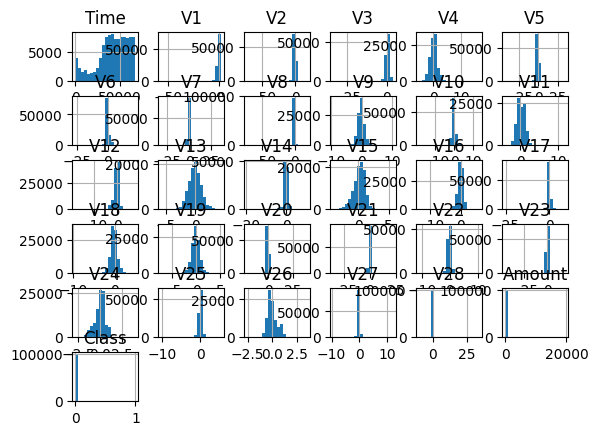

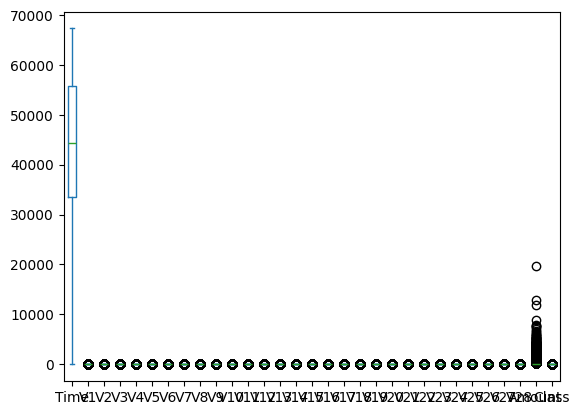

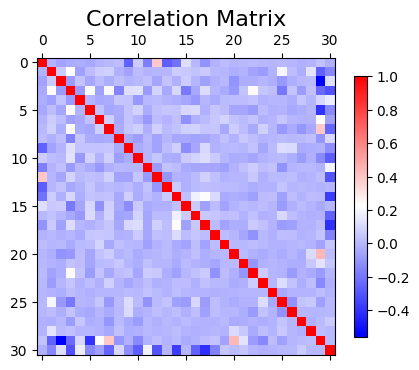

Number of normal examples = 99775
Number of fraud examples = 223

Normal to fraud ratio = 447.42
Updated feature dimension: 32 (should be a power of 2)
(312, 32) (134, 32) (312,) (134,)


<ipython-input-2-0a3966ce649f>:87: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91       157
         1.0       1.00      0.79      0.88       155

    accuracy                           0.90       312
   macro avg       0.92      0.90      0.90       312
weighted avg       0.91      0.90      0.90       312

[[157   0]
 [ 32 123]] = Confusion Matrix (Train Set)
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92        66
         1.0       1.00      0.82      0.90        68

    accuracy                           0.91       134
   macro avg       0.92      0.91      0.91       134
weighted avg       0.92      0.91      0.91       134

[[66  0]
 [12 56]] = Confusion Matrix (Test Set)
0.91 = ROC AUC Score (Test Set)
                     LogisticRegression() 

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93       157
         1.0       1.00      0.85      0.92       155

   

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       157
         1.0       0.99      0.86      0.92       155

    accuracy                           0.93       312
   macro avg       0.94      0.93      0.93       312
weighted avg       0.94      0.93      0.93       312

[[156   1]
 [ 21 134]] = Confusion Matrix (Train Set)
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        66
         1.0       1.00      0.93      0.96        68

    accuracy                           0.96       134
   macro avg       0.96      0.96      0.96       134
weighted avg       0.97      0.96      0.96       134

[[66  0]
 [ 5 63]] = Confusion Matrix (Test Set)
0.96 = ROC AUC Score (Test Set)
                     SVC() 

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93       157
         1.0       1.00      0.85      0.92       155

    accuracy      

In [2]:
### 1. Install and Upgrade Dependencies
!pip install --upgrade pip
!pip install --upgrade qiskit
!pip install qiskit_machine_learning
!pip install qiskit_aer
!pip install qiskit_algorithms

### 2. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, copy, warnings

from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_algorithms.optimizers import COBYLA  # Updated import
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC

### 3. Data Loading and Preprocessing
try:
    data = pd.read_csv('/content/creditcard.csv', delimiter=',', on_bad_lines='warn')
except pd.errors.ParserError as e:
    print(f"Error reading CSV: {e}")

### 4. Exploratory Data Analysis (EDA)
data.hist(bins=20)
data.plot.box()

numeric_data = data.select_dtypes(include=np.number)
plt.matshow(numeric_data.corr(), cmap='bwr')
plt.colorbar(shrink=0.7)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

### 5. Data Preparation for Quantum Machine Learning
normal = data[data.Class == 0]
fraud = data[data.Class == 1]
num_normal, num_fraud = normal.shape[0], fraud.shape[0]

print(f"Number of normal examples = {num_normal}")
print(f"Number of fraud examples = {num_fraud}\n")
ratio = num_normal / num_fraud
print(f'Normal to fraud ratio = {round(ratio,2)}')

normal_sample = normal.sample(num_fraud)
sample = pd.concat([fraud, normal_sample], axis=0)
sample = np.random.permutation(sample)

X, y = sample[:, :-1], sample[:, -1]
X = MinMaxScaler().fit_transform(X)
num_examples, num_features = X.shape

### 6. Adjust Feature Dimension to Power of 2
def is_power_of_2(n):
    return (n & (n - 1)) == 0 and n > 0

n = int(np.ceil(np.log2(num_features)))
dim = 2**n

if num_features != dim:
    zeros = np.zeros((num_examples, dim - num_features))
    X = np.append(X, zeros, axis=1)
    num_features = X.shape[1]

print(f"Updated feature dimension: {num_features} (should be a power of 2)")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

### 7. Feature Mapping and Quantum Circuit Setup
fm = RawFeatureVector(feature_dimension=num_features)
fm.draw()

pqc = RealAmplitudes(num_qubits=n, reps=3)
pqc.decompose().draw()

### 8. Training and Evaluation with Quantum Classifier
optimizer = COBYLA(maxiter=150)
sampler = Sampler()
objective_func_vals = []

def callback(weights, obj_func_eval):
    from IPython.display import clear_output
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

vqc = VQC(sampler=sampler, feature_map=fm, ansatz=pqc, optimizer=optimizer, callback=callback)

vqc.fit(X_train, y_train)

y_train_pred = vqc.predict(X_train)
y_test_pred = vqc.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred), "= Confusion Matrix (Train Set)")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred), "= Confusion Matrix (Test Set)")
print(round(roc_auc_score(y_test, y_test_pred), 2), "= ROC AUC Score (Test Set)")

### 9. Classical Machine Learning Model Comparisons
def train_test(ML_model):
    print(20*' ', ML_model,'\n')
    ML_model.fit(X_train, y_train)
    y_train_pred = ML_model.predict(X_train)
    y_test_pred = ML_model.predict(X_test)
    print(classification_report(y_train, y_train_pred))
    print(confusion_matrix(y_train, y_train_pred), "= Confusion Matrix (Train Set)")
    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred), "= Confusion Matrix (Test Set)")
    print(round(roc_auc_score(y_test, y_test_pred), 2), "= ROC AUC Score (Test Set)")
    print(70*'=')

print(70*'=')
train_test(linear_model.LogisticRegression())
train_test(MLPClassifier())
train_test(svm.SVC())
train_test(RandomForestClassifier())
